<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

Libraries installation

In [ ]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [ ]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [ ]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [ ]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [ ]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_PAD_IND = 2
MAX_DUR = 511 # equivalent to 16 bars (with RESOLUTION=32)

RESOLUTION = 32
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes) if notes else 0
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION) == 0 \
                                else length + (RESOLUTION-(length%(RESOLUTION)))


        tracks_tensors = []
        tracks_activations = []

        dur_bin_length = int(np.ceil(np.log2(MAX_DUR)))

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time

                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue

                track_tensor[t, notes_counter[t], 0] = note.pitch
                track_tensor[t, notes_counter[t], 1] = note.duration
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS

            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)

            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION+1, RESOLUTION):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION]

            if NUM_BARS > 1:
                # Skip sequence if it contains more than one bar of consecutive
                # silence in at least one track
                bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
                bars_acts = np.any(bars, axis=2)

                if 1 in np.diff(np.where(bars_acts == 0)[1]):
                    continue
            else:
                # In the case of just 1 bar, skip it if all tracks are silenced
                bar_acts = np.any(seq_acts, axis=1)
                if not np.any(bar_acts):
                    continue
                

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_EOS)
            seq_tensor[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples




# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, num_files=45129, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    not_filtered = 0
    finished = False
    
    print("Starting preprocessing")
    
    progress_bar = tqdm(range(early_exit)) if early_exit is not None else tqdm(range(num_files))
    start = time.time()

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)
        print()

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            n_saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += n_saved
            if n_saved > 0:
                not_filtered += 1
            
            progress_bar.update(1)
            
            # Todo: also print # of processed (not filtered) files
            #       and # of produced sequences (samples)
            print("Total number of seen files:", seen)
            print("Number of unique files:", len(files_dict))
            print("Total number of non filtered songs:", not_filtered)
            print("Total number of saved samples:", tot_samples)
            print()

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        if finished:
            break
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Preprocessing completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours),int(minutes),seconds))


In [ ]:
!rm -rf data/preprocessed/
!mkdir data/preprocessed

In [8]:
dataset_dir = 'data/lmd_matched'
dest_dir = 'data/preprocessed'

Check preprocessed data:

In [9]:
preprocess_dataset(dataset_dir, dest_dir, early_exit=1)

Starting preprocessing


  0%|          | 0/1 [00:00<?, ?it/s]

Current path: data/lmd_matched

Current path: data/lmd_matched/A

Current path: data/lmd_matched/A/A

Current path: data/lmd_matched/A/A/A

Current path: data/lmd_matched/A/A/A/TRAAAGR128F425B14B

Preprocessing file data/lmd_matched/A/A/A/TRAAAGR128F425B14B/1d9d16a9da90c090809c153754823c2b.mid
Processing combination 1 of 7
Processing combination 2 of 7
Processing combination 3 of 7
Processing combination 4 of 7
Processing combination 5 of 7
Processing combination 6 of 7
Processing combination 7 of 7
File preprocessing finished. Saved samples: 3031

Total number of seen files: 1
Number of unique files: 1
Total number of non filtered songs: 1
Total number of saved samples: 3031

Preprocessing completed in (h:m:s): 00:00:03.55


In [10]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [11]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [12]:
data["seq_tensor"][0, 0]

array([[128,   0],
       [129,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0]], dtype=int16)

# Model

In [13]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot[np.arange(0, onehot.shape[0]), pitches.reshape(-1)] = 1.
        onehot = onehot.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to binary (pitch)
        durs = seq_tensor[:, :, :, 1]
        bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]

        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot[:, :, :, :], bin_durs),
                             axis=-1)
        
        # Construct graph from boolean activations
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        n = seq_acts.shape[0]*seq_acts.shape[1]
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph


In [14]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        self.dropout = dropout
        
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
            

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=140, d_transf=256, nhead_transf=4, 
                 num_layers_transf=2, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

    def forward(self, x_seq, x_acts, x_graph):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        # Todo: src_key_padding_mask = (src != pad).unsqueeze(-2) ?
        transformer_encs = self.transformer_encoder(pos_encs)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        num_nodes = x_graph[0].num_nodes
        batch_sz = node_encs.size(0) // num_nodes
        node_encs = node_encs.view(batch_sz, num_nodes, -1)
        encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=140, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=2, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, 140)


    def forward(self, z, x_seq, x_acts, x_graph):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        node_features = torch.repeat_interleave(
                            z, x_acts.size(-1)*x_acts.size(-2), axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        embs = self.embedding(seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    def forward(self, x_seq, x_acts, x_graph):
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        out = self.decoder(z, x_seq, x_acts, x_graph)
        
        return out, mu, log_var


Trainer

In [35]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy
import time
from statistics import mean
from collections import defaultdict


class VAETrainer():
    
    def __init__(self, model, models_path, optimizer, init_lr,
                 name=None, lr_scheduler=None, device=torch.device("cuda"), 
                 print_every=1, save_every=1):
        
        self.model = model
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.name = name if name is not None else str(uuid.uuid4())
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
        self.model_path = os.path.join(self.models_path, self.name)
        
        # Criteria with ignored padding
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce = nn.CrossEntropyLoss(ignore_index=130)
        
        # Training stats
        self.losses = defaultdict(list)
        self.accuracies = defaultdict(list)
        self.lrs = []
        self.times = []
        
    
    def train(self, trainloader, validloader=None, epochs=1,
              early_exit=None):
        
        n_batches = len(trainloader)

        beta = 0 # Todo: _update_params()
        
        self.model.train()
        
        print("Starting training.\n")
        
        start = time.time()
        self.times.append(start)
        
        tot_batches = 0
        
        for epoch in range(epochs):
            
            self.cur_epoch = epoch
            progress_bar = tqdm(range(n_batches))
            
            for batch_idx, inputs in enumerate(trainloader):
                
                self.cur_batch_idx = batch_idx
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq, x_acts, x_graph = inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)
                inputs = (x_seq, x_acts, x_graph)

                # Forward pass, get the reconstructions
                outputs, mu, log_var = self.model(x_seq, x_acts, x_graph)
                
                # Compute the backprop loss and other required losses
                tot_loss, losses = self._compute_losses(inputs, outputs, mu,
                                                         log_var, beta)
                
                # Backprop and update lr
                tot_loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                    
                # Update the stats
                self._append_losses(losses)
                
                last_lr = (self.lr_scheduler.get_last_lr()[0] 
                               if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                
                accs = self._compute_accuracies(inputs, outputs)
                self._append_accuracies(accs)
                
                now = time.time()
                self.times.append(now)
                
                # Print stats
                if (tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1, n_batches, epoch+1, epochs))
                    self._print_stats()
                    #print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          #.format(running_loss/self.print_every, acts_loss), end='')
                    #print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          #.format(pitches_loss, dur_loss, kld_loss))
                    print("\n----------------------------------------\n")
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (tot_batches + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    self._save_model()
                
                progress_bar.update(1)
                
                # Stop prematurely if early_exit is set and reached
                if early_exit is not None and (tot_batches + 1) > early_exit:
                    break
                    
                tot_batches += 1
            

        end = time.time()
        # Todo: self.__print_time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        self._save_model()
        
        print("Model saved.")
        
    
    def _compute_losses(self, inputs, outputs, mu, log_var, beta):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Pad mask
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        mask = (pitches_true != 130).unsqueeze(-1)
        
        # Compute the losses
        losses = {}
        acts_loss = self.bce(acts_rec.view(-1), x_acts.view(-1).float())
        pitches_loss = self.ce(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                          x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
        #dur_loss = self.bce(seq_rec[..., 131:].reshape(-1), 
                       #x_seq[..., 131:].reshape(-1))
        dur_loss = self.bce_unreduced(seq_rec[..., 131:],
                            x_seq[..., 131:])
        dur_loss = mask * dur_loss
        dur_loss = torch.sum(dur_loss) / torch.sum(mask)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_loss = pitches_loss + dur_loss + acts_loss
        tot_loss = rec_loss + beta*kld_loss
        
        losses = {
            'tot': tot_loss.item(),
            'pitches': pitches_loss.item(),
            'dur': dur_loss.item(),
            'acts': acts_loss.item(),
            'rec': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': beta*kld_loss.item()
        }
        
        return tot_loss, losses

    
    def _append_losses(self, losses):
        
        for k, loss in losses.items():
            self.losses[k].append(loss)
            
            
    def _compute_accuracies(self, inputs, outputs):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        notes_acc = self._note_accuracy(seq_rec, x_seq)
        pitches_acc = self._pitches_accuracy(seq_rec, x_seq)
        dur_acc = self._dur_accuracy(seq_rec, x_seq)
        acts_acc = self._acts_accuracy(acts_rec, x_acts)
        
        accs = {
            'notes': notes_acc.item(),
            'pitches': pitches_acc.item(),
            'dur': dur_acc.item(),
            'acts': acts_acc.item()
        }
        
        return accs
        
        
    def _append_accuracies(self, accs):
        
        for k, acc in accs.items():
            self.accuracies[k].append(acc)
    
    
    def _acts_accuracy(self, acts_rec, x_acts):
        
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        
        return torch.sum(acts_rec == x_acts) / x_acts.numel()
    
    
    def _pitches_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        preds_pitches = (pitches_rec == pitches_true)
        
        # Pad mask
        mask = (pitches_true != 130)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        return torch.sum(preds_pitches) / torch.sum(mask)
    
    
    def _dur_accuracy(self, seq_rec, x_seq):
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        
        # Pad mask
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        mask = (pitches_true != 130)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(preds_dur) / torch.sum(mask)
    
    
    def _note_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        preds_pitches = (pitches_rec == pitches_true)
        
        # Pad mask
        mask = (pitches_true != 130)
        preds_pitches = torch.logical_and(preds_pitches, mask)

        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(torch.logical_and(preds_pitches, preds_dur)) / torch.sum(mask)
    
    
    def _save_model(self):
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'save_every': self.save_every,
            'lrs': self.lrs,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, self.model_path)
        
        
    def _print_stats(self):
        
        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours), int(minutes), seconds))
        
        avg_lr = mean(self.lrs[-self.print_every:])
        
        # Take mean of the last non-printed batches for each stat
        
        avg_losses = {}
        for k, l in self.losses.items():
            avg_losses[k] = mean(l[-self.print_every:])
        
        avg_accs = {}
        for k, l in self.accuracies.items():
            avg_accs[k] = mean(l[-self.print_every:])
        
        print("Losses:")
        print(avg_losses)
        print("Accuracies:")
        print(avg_accs)
        
        
        


Training

In [37]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [38]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)

3031

In [39]:
import torch
torch.cuda.set_device(2)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 2


In [29]:
!rm models/vae

In [40]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [47]:
print("Creating the model and moving it to the specified device...")

vae = VAE().to(device)
print_params(vae)
print()

init_lr = 1e-5
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(
    vae,
    models_path,
    optimizer,
    init_lr,
    name='vae',
    lr_scheduler=scheduler,
    save_every=100, 
    device=device
)
trainer.train(loader, epochs=10)

Creating the model and moving it to the specified device...
+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                    encoder.embedding.weight                    |   35840    |
|                     encoder.embedding.bias                     |    256     |
| encoder.transformer_encoder.layers.0.self_attn.in_proj_weight  |   196608   |
|  encoder.transformer_encoder.layers.0.self_attn.in_proj_bias   |    768     |
| encoder.transformer_encoder.layers.0.self_attn.out_proj.weight |   65536    |
|  encoder.transformer_encoder.layers.0.self_attn.out_proj.bias  |    256     |
|      encoder.transformer_encoder.layers.0.linear1.weight       |   524288   |
|       encoder.transformer_encoder.layers.0.linear1.bias        |    2048    |
|      encoder.transformer_encoder.layers.0.linear2.weight  

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:00.43
Losses:
{'tot': 12.691286087036133, 'pitches': 4.743009567260742, 'dur': 7.195504665374756, 'acts': 0.75277179479599, 'rec': 12.691286087036133, 'kld': 340.76165771484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0006994637660682201, 'dur': 0.0, 'acts': 0.486328125}

----------------------------------------

Training on batch 2/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:00.85
Losses:
{'tot': 12.495670318603516, 'pitches': 4.7153849601745605, 'dur': 7.03643798828125, 'acts': 0.7438464164733887, 'rec': 12.495670318603516, 'kld': 339.60174560546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.000702329387422651, 'dur': 0.0, 'acts': 0.496337890625}

----------------------------------------

Training on batch 3/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:01.27
Losses:
{'tot': 12.193650245666504, 'pitches': 4.678381443023682, 'd

Training on batch 20/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:08.23
Losses:
{'tot': 8.848071098327637, 'pitches': 3.9729487895965576, 'dur': 4.139072418212891, 'acts': 0.7360498905181885, 'rec': 8.848071098327637, 'kld': 490.20660400390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.04506613686680794, 'pitches': 0.14748917520046234, 'dur': 0.40594640374183655, 'acts': 0.503173828125}

----------------------------------------

Training on batch 21/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:08.64
Losses:
{'tot': 8.685032844543457, 'pitches': 3.9539268016815186, 'dur': 3.995120048522949, 'acts': 0.7359855771064758, 'rec': 8.685032844543457, 'kld': 506.57763671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.087612584233284, 'pitches': 0.19768394529819489, 'dur': 0.5207626819610596, 'acts': 0.500732421875}

----------------------------------------

Training on batch 22/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:09.04
Losses:

Training on batch 39/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:15.95
Losses:
{'tot': 6.565662860870361, 'pitches': 3.157364845275879, 'dur': 2.6841838359832764, 'acts': 0.7241140604019165, 'rec': 6.565662860870361, 'kld': 817.1357421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5044403076171875, 'pitches': 0.5052582621574402, 'dur': 0.9560645222663879, 'acts': 0.522705078125}

----------------------------------------

Training on batch 40/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:16.36
Losses:
{'tot': 6.451180934906006, 'pitches': 3.093791961669922, 'dur': 2.626096248626709, 'acts': 0.7312927842140198, 'rec': 6.451180934906006, 'kld': 834.7590942382812, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5117481350898743, 'pitches': 0.5126879811286926, 'dur': 0.9612312316894531, 'acts': 0.516845703125}

----------------------------------------

Training on batch 41/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:16.77
Losses:
{'tot

Training on batch 58/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:23.68
Losses:
{'tot': 5.196661472320557, 'pitches': 2.4195244312286377, 'dur': 2.0573832988739014, 'acts': 0.7197538614273071, 'rec': 5.196661472320557, 'kld': 1219.0673828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5768190622329712, 'pitches': 0.5768190622329712, 'dur': 0.9629716873168945, 'acts': 0.525390625}

----------------------------------------

Training on batch 59/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:24.10
Losses:
{'tot': 5.124295711517334, 'pitches': 2.3741037845611572, 'dur': 2.0377004146575928, 'acts': 0.7124914526939392, 'rec': 5.124295711517334, 'kld': 1240.2705078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.58307945728302, 'pitches': 0.58307945728302, 'dur': 0.9599249958992004, 'acts': 0.54541015625}

----------------------------------------

Training on batch 60/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:24.49
Losses:
{'tot': 5.0

Training on batch 77/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:31.41
Losses:
{'tot': 4.36097526550293, 'pitches': 1.9087916612625122, 'dur': 1.7606430053710938, 'acts': 0.6915406584739685, 'rec': 4.36097526550293, 'kld': 1597.1976318359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.6578885316848755, 'pitches': 0.6578885316848755, 'dur': 0.963084876537323, 'acts': 0.5576171875}

----------------------------------------

Training on batch 78/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:31.81
Losses:
{'tot': 4.361641883850098, 'pitches': 1.8970643281936646, 'dur': 1.7674062252044678, 'acts': 0.6971709728240967, 'rec': 4.361641883850098, 'kld': 1619.154296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.6685419678688049, 'pitches': 0.6685419678688049, 'dur': 0.9601500034332275, 'acts': 0.551025390625}

----------------------------------------

Training on batch 79/95 of epoch 1/10 complete.
Elapsed time from start (h:m:s): 00:00:32.21
Losses:
{'tot'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:39.03
Losses:
{'tot': 3.8868613243103027, 'pitches': 1.6757779121398926, 'dur': 1.5264177322387695, 'acts': 0.6846656799316406, 'rec': 3.8868613243103027, 'kld': 1927.8623046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.7216095924377441, 'pitches': 0.7216095924377441, 'dur': 0.9610511660575867, 'acts': 0.5751953125}

----------------------------------------

Training on batch 2/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:39.44
Losses:
{'tot': 3.8789143562316895, 'pitches': 1.6761192083358765, 'dur': 1.529672622680664, 'acts': 0.6731223464012146, 'rec': 3.8789143562316895, 'kld': 1934.591796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.7182307243347168, 'pitches': 0.7182307243347168, 'dur': 0.9585770964622498, 'acts': 0.591064453125}

----------------------------------------

Training on batch 3/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:39.84
Losses:
{'tot'

Training on batch 20/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:46.95
Losses:
{'tot': 3.587994337081909, 'pitches': 1.5166624784469604, 'dur': 1.414771318435669, 'acts': 0.6565606594085693, 'rec': 3.587994337081909, 'kld': 2192.5029296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.7859821915626526, 'pitches': 0.7859821915626526, 'dur': 0.9601500034332275, 'acts': 0.60986328125}

----------------------------------------

Training on batch 21/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:47.37
Losses:
{'tot': 3.5680644512176514, 'pitches': 1.5159046649932861, 'dur': 1.3973028659820557, 'acts': 0.6548569202423096, 'rec': 3.5680644512176514, 'kld': 2222.14208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.7908174991607666, 'pitches': 0.7908174991607666, 'dur': 0.9594752788543701, 'acts': 0.606201171875}

----------------------------------------

Training on batch 22/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:47.78
Losses:
{'

Training on batch 39/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:54.75
Losses:
{'tot': 3.3595259189605713, 'pitches': 1.4264994859695435, 'dur': 1.3046852350234985, 'acts': 0.6283411979675293, 'rec': 3.3595259189605713, 'kld': 2486.23291015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.8206928968429565, 'pitches': 0.8206928968429565, 'dur': 0.9588015079498291, 'acts': 0.64111328125}

----------------------------------------

Training on batch 40/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:55.16
Losses:
{'tot': 3.389735698699951, 'pitches': 1.4440268278121948, 'dur': 1.3143340349197388, 'acts': 0.6313749551773071, 'rec': 3.389735698699951, 'kld': 2509.507568359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.8262490034103394, 'pitches': 0.8262490034103394, 'dur': 0.9540002346038818, 'acts': 0.65380859375}

----------------------------------------

Training on batch 41/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:00:55.57
Losses:


Training on batch 58/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:01:02.47
Losses:
{'tot': 3.2025086879730225, 'pitches': 1.3480616807937622, 'dur': 1.2539823055267334, 'acts': 0.6004645824432373, 'rec': 3.2025086879730225, 'kld': 2813.518310546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.8563916683197021, 'pitches': 0.8563916683197021, 'dur': 0.9572330117225647, 'acts': 0.677978515625}

----------------------------------------

Training on batch 59/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:01:02.87
Losses:
{'tot': 3.194563388824463, 'pitches': 1.349725604057312, 'dur': 1.241923451423645, 'acts': 0.6029144525527954, 'rec': 3.194563388824463, 'kld': 2827.5654296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.8620166182518005, 'pitches': 0.8620166182518005, 'dur': 0.9571211338043213, 'acts': 0.6845703125}

----------------------------------------

Training on batch 60/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:01:03.28
Losses:
{'t

Training on batch 77/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:01:10.23
Losses:
{'tot': 3.0738048553466797, 'pitches': 1.2856332063674927, 'dur': 1.218675136566162, 'acts': 0.5694966912269592, 'rec': 3.0738048553466797, 'kld': 3196.88232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.8887462019920349, 'pitches': 0.8887462019920349, 'dur': 0.9563390016555786, 'acts': 0.718505859375}

----------------------------------------

Training on batch 78/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:01:10.64
Losses:
{'tot': 3.042393684387207, 'pitches': 1.2776457071304321, 'dur': 1.195156216621399, 'acts': 0.5695918798446655, 'rec': 3.042393684387207, 'kld': 3219.32177734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.8814511299133301, 'pitches': 0.8814511299133301, 'dur': 0.958689272403717, 'acts': 0.722412109375}

----------------------------------------

Training on batch 79/95 of epoch 2/10 complete.
Elapsed time from start (h:m:s): 00:01:11.04
Losses:
{'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:17.83
Losses:
{'tot': 2.894087314605713, 'pitches': 1.210546612739563, 'dur': 1.1467396020889282, 'acts': 0.5368009805679321, 'rec': 2.894087314605713, 'kld': 3643.573974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9111683964729309, 'pitches': 0.9111683964729309, 'dur': 0.9600375294685364, 'acts': 0.75732421875}

----------------------------------------

Training on batch 2/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:18.23
Losses:
{'tot': 2.9166831970214844, 'pitches': 1.22190523147583, 'dur': 1.147718071937561, 'acts': 0.5470601320266724, 'rec': 2.9166831970214844, 'kld': 3678.286865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9108563661575317, 'pitches': 0.9108563661575317, 'dur': 0.95835280418396, 'acts': 0.750732421875}

----------------------------------------

Training on batch 3/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:18.63
Losses:
{'tot':

Training on batch 20/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:25.66
Losses:
{'tot': 2.790788173675537, 'pitches': 1.1657673120498657, 'dur': 1.1142730712890625, 'acts': 0.5107477903366089, 'rec': 2.790788173675537, 'kld': 4166.23828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9273259043693542, 'pitches': 0.9273259043693542, 'dur': 0.958689272403717, 'acts': 0.776123046875}

----------------------------------------

Training on batch 21/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:26.07
Losses:
{'tot': 2.787269353866577, 'pitches': 1.1709197759628296, 'dur': 1.1123203039169312, 'acts': 0.5040292739868164, 'rec': 2.787269353866577, 'kld': 4189.8544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9292303919792175, 'pitches': 0.9292303919792175, 'dur': 0.9566740393638611, 'acts': 0.780517578125}

----------------------------------------

Training on batch 22/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:26.47
Losses:
{'tot'

Training on batch 39/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:33.33
Losses:
{'tot': 2.711684465408325, 'pitches': 1.1338751316070557, 'dur': 1.0967556238174438, 'acts': 0.48105359077453613, 'rec': 2.711684465408325, 'kld': 4723.515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9367662668228149, 'pitches': 0.9367662668228149, 'dur': 0.9522259831428528, 'acts': 0.81396484375}

----------------------------------------

Training on batch 40/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:33.73
Losses:
{'tot': 2.6533203125, 'pitches': 1.0940275192260742, 'dur': 1.0747767686843872, 'acts': 0.4845161437988281, 'rec': 2.6533203125, 'kld': 4755.57568359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9410247206687927, 'pitches': 0.9410247206687927, 'dur': 0.9604877233505249, 'acts': 0.7998046875}

----------------------------------------

Training on batch 41/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:34.15
Losses:
{'tot': 2.67369556

Training on batch 58/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:41.12
Losses:
{'tot': 2.562958002090454, 'pitches': 1.0491758584976196, 'dur': 1.0634129047393799, 'acts': 0.45036906003952026, 'rec': 2.562958002090454, 'kld': 5369.390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9472576379776001, 'pitches': 0.9472576379776001, 'dur': 0.9580166339874268, 'acts': 0.84130859375}

----------------------------------------

Training on batch 59/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:41.52
Losses:
{'tot': 2.5331223011016846, 'pitches': 1.0313029289245605, 'dur': 1.0511163473129272, 'acts': 0.45070284605026245, 'rec': 2.5331223011016846, 'kld': 5358.939453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9491783976554871, 'pitches': 0.9491783976554871, 'dur': 0.9615023732185364, 'acts': 0.838623046875}

----------------------------------------

Training on batch 60/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:41.95
Losses:
{'tot

Training on batch 77/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:48.97
Losses:
{'tot': 2.451580047607422, 'pitches': 0.9876874685287476, 'dur': 1.0463225841522217, 'acts': 0.4175700545310974, 'rec': 2.451580047607422, 'kld': 5969.31982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.953667938709259, 'pitches': 0.953667938709259, 'dur': 0.9584649801254272, 'acts': 0.868896484375}

----------------------------------------

Training on batch 78/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:49.38
Losses:
{'tot': 2.412367582321167, 'pitches': 0.9647912979125977, 'dur': 1.0250931978225708, 'acts': 0.4224831759929657, 'rec': 2.412367582321167, 'kld': 5996.265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9572217464447021, 'pitches': 0.9572217464447021, 'dur': 0.9627453088760376, 'acts': 0.86572265625}

----------------------------------------

Training on batch 79/95 of epoch 3/10 complete.
Elapsed time from start (h:m:s): 00:01:49.78
Losses:
{'tot': 2

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:01:56.59
Losses:
{'tot': 2.3621654510498047, 'pitches': 0.9370885491371155, 'dur': 1.0205315351486206, 'acts': 0.40454530715942383, 'rec': 2.3621654510498047, 'kld': 6678.1611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.953801155090332, 'pitches': 0.953801155090332, 'dur': 0.9581286311149597, 'acts': 0.879638671875}

----------------------------------------

Training on batch 2/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:01:57.01
Losses:
{'tot': 2.3581624031066895, 'pitches': 0.9450730085372925, 'dur': 1.0153257846832275, 'acts': 0.39776358008384705, 'rec': 2.3581624031066895, 'kld': 6704.5849609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9520252346992493, 'pitches': 0.9520252346992493, 'dur': 0.9562273621559143, 'acts': 0.8818359375}

----------------------------------------

Training on batch 3/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:01:57.43
Losses:
{'to

Training on batch 20/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:04.68
Losses:
{'tot': 2.24522066116333, 'pitches': 0.8751247525215149, 'dur': 0.9994879364967346, 'acts': 0.370607852935791, 'rec': 2.24522066116333, 'kld': 7443.6220703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9563793540000916, 'pitches': 0.9563793540000916, 'dur': 0.9580166339874268, 'acts': 0.905029296875}

----------------------------------------

Training on batch 21/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:05.09
Losses:
{'tot': 2.2555954456329346, 'pitches': 0.8937034010887146, 'dur': 0.9935508966445923, 'acts': 0.3683412969112396, 'rec': 2.2555954456329346, 'kld': 7476.9560546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9533309936523438, 'pitches': 0.9533309936523438, 'dur': 0.955781102180481, 'acts': 0.90625}

----------------------------------------

Training on batch 22/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:05.50
Losses:
{'tot': 2.25

Training on batch 39/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:12.54
Losses:
{'tot': 2.1682167053222656, 'pitches': 0.8330575227737427, 'dur': 0.9723211526870728, 'acts': 0.36283814907073975, 'rec': 2.1682167053222656, 'kld': 8256.1259765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9563946723937988, 'pitches': 0.9563946723937988, 'dur': 0.9576806426048279, 'acts': 0.9052734375}

----------------------------------------

Training on batch 40/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:12.95
Losses:
{'tot': 2.1532163619995117, 'pitches': 0.8264675140380859, 'dur': 0.9792062640190125, 'acts': 0.3475426137447357, 'rec': 2.1532163619995117, 'kld': 8283.94921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9552883505821228, 'pitches': 0.9552883505821228, 'dur': 0.9563390016555786, 'acts': 0.920166015625}

----------------------------------------

Training on batch 41/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:13.35
Losses:
{'

Training on batch 58/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:20.34
Losses:
{'tot': 2.0197134017944336, 'pitches': 0.7417164444923401, 'dur': 0.9488622546195984, 'acts': 0.32913467288017273, 'rec': 2.0197134017944336, 'kld': 9133.470703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9626058340072632, 'pitches': 0.9626058340072632, 'dur': 0.9633113741874695, 'acts': 0.92138671875}

----------------------------------------

Training on batch 59/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:20.75
Losses:
{'tot': 2.0393922328948975, 'pitches': 0.7626875638961792, 'dur': 0.9525314569473267, 'acts': 0.32417330145835876, 'rec': 2.0393922328948975, 'kld': 9194.94140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9585431814193726, 'pitches': 0.9585431814193726, 'dur': 0.9593629240989685, 'acts': 0.92822265625}

----------------------------------------

Training on batch 60/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:21.15
Losses:
{'

Training on batch 77/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:28.05
Losses:
{'tot': 1.971339464187622, 'pitches': 0.7222387194633484, 'dur': 0.941648542881012, 'acts': 0.30745217204093933, 'rec': 1.971339464187622, 'kld': 10098.3359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9585625529289246, 'pitches': 0.9585625529289246, 'dur': 0.9589137434959412, 'acts': 0.9384765625}

----------------------------------------

Training on batch 78/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:28.45
Losses:
{'tot': 2.0023133754730225, 'pitches': 0.7487128376960754, 'dur': 0.9504501819610596, 'acts': 0.3031504452228546, 'rec': 2.0023133754730225, 'kld': 10145.8955078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9544395208358765, 'pitches': 0.9544395208358765, 'dur': 0.9545560479164124, 'acts': 0.93994140625}

----------------------------------------

Training on batch 79/95 of epoch 4/10 complete.
Elapsed time from start (h:m:s): 00:02:28.86
Losses:
{'tot

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:35.73
Losses:
{'tot': 1.8722425699234009, 'pitches': 0.6741871237754822, 'dur': 0.9158572554588318, 'acts': 0.2821981906890869, 'rec': 1.8722425699234009, 'kld': 11111.287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9602252840995789, 'pitches': 0.9602252840995789, 'dur': 0.9611639380455017, 'acts': 0.94140625}

----------------------------------------

Training on batch 2/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:36.13
Losses:
{'tot': 1.8635412454605103, 'pitches': 0.6634013056755066, 'dur': 0.9145389199256897, 'acts': 0.2856009900569916, 'rec': 1.8635412454605103, 'kld': 11131.548828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9630631804466248, 'pitches': 0.9630631804466248, 'dur': 0.9636513590812683, 'acts': 0.943115234375}

----------------------------------------

Training on batch 3/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:36.56
Losses:
{'tot'

Training on batch 20/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:43.49
Losses:
{'tot': 1.8414217233657837, 'pitches': 0.6710280179977417, 'dur': 0.9097977876663208, 'acts': 0.2605958878993988, 'rec': 1.8414217233657837, 'kld': 12160.3447265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9561106562614441, 'pitches': 0.9561106562614441, 'dur': 0.9562273621559143, 'acts': 0.9521484375}

----------------------------------------


Saving model to disk...

Training on batch 21/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:44.11
Losses:
{'tot': 1.8180692195892334, 'pitches': 0.6467716097831726, 'dur': 0.9097737669944763, 'acts': 0.26152390241622925, 'rec': 1.8180692195892334, 'kld': 12196.794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9590020179748535, 'pitches': 0.9590020179748535, 'dur': 0.9595876932144165, 'acts': 0.954345703125}

----------------------------------------

Training on batch 22/95 of epoch 5/10 complete.
Elapsed time from start (h

Training on batch 39/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:51.46
Losses:
{'tot': 1.770374059677124, 'pitches': 0.621711790561676, 'dur': 0.8972325921058655, 'acts': 0.25142961740493774, 'rec': 1.770374059677124, 'kld': 13211.697265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9602625966072083, 'pitches': 0.9602625966072083, 'dur': 0.9602625966072083, 'acts': 0.951904296875}

----------------------------------------

Training on batch 40/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:51.87
Losses:
{'tot': 1.7773635387420654, 'pitches': 0.6264470815658569, 'dur': 0.8969303369522095, 'acts': 0.2539861798286438, 'rec': 1.7773635387420654, 'kld': 13319.19921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9583333134651184, 'pitches': 0.9583333134651184, 'dur': 0.9588015079498291, 'acts': 0.948974609375}

----------------------------------------

Training on batch 41/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:52.27
Losses:
{'

Training on batch 58/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:59.24
Losses:
{'tot': 1.7048203945159912, 'pitches': 0.5927422046661377, 'dur': 0.8768125176429749, 'acts': 0.23526576161384583, 'rec': 1.7048203945159912, 'kld': 14327.27734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9611639380455017, 'pitches': 0.9611639380455017, 'dur': 0.9611639380455017, 'acts': 0.9541015625}

----------------------------------------

Training on batch 59/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:02:59.66
Losses:
{'tot': 1.7098311185836792, 'pitches': 0.6003239750862122, 'dur': 0.8758874535560608, 'acts': 0.23361973464488983, 'rec': 1.7098311185836792, 'kld': 14380.2919921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.959133505821228, 'pitches': 0.959133505821228, 'dur': 0.9592505693435669, 'acts': 0.954833984375}

----------------------------------------

Training on batch 60/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:03:00.06
Losses:
{

Training on batch 77/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:03:07.15
Losses:
{'tot': 1.6743090152740479, 'pitches': 0.5804193615913391, 'dur': 0.8666532039642334, 'acts': 0.22723650932312012, 'rec': 1.6743090152740479, 'kld': 15372.5732421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9599109292030334, 'pitches': 0.9599109292030334, 'dur': 0.9602625966072083, 'acts': 0.95068359375}

----------------------------------------

Training on batch 78/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:03:07.55
Losses:
{'tot': 1.6799787282943726, 'pitches': 0.5903646945953369, 'dur': 0.8649794459342957, 'acts': 0.2246345728635788, 'rec': 1.6799787282943726, 'kld': 15438.380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9589089155197144, 'pitches': 0.9589089155197144, 'dur': 0.9590259790420532, 'acts': 0.953125}

----------------------------------------

Training on batch 79/95 of epoch 5/10 complete.
Elapsed time from start (h:m:s): 00:03:07.97
Losses:
{'to

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:14.98
Losses:
{'tot': 1.6518652439117432, 'pitches': 0.5850773453712463, 'dur': 0.8617078065872192, 'acts': 0.2050800770521164, 'rec': 1.6518652439117432, 'kld': 16493.84765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9566689729690552, 'pitches': 0.9566689729690552, 'dur': 0.9567857980728149, 'acts': 0.9599609375}

----------------------------------------

Training on batch 2/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:15.38
Losses:
{'tot': 1.6314373016357422, 'pitches': 0.5705638527870178, 'dur': 0.8539722561836243, 'acts': 0.20690122246742249, 'rec': 1.6314373016357422, 'kld': 16521.630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9593629240989685, 'pitches': 0.9593629240989685, 'dur': 0.9593629240989685, 'acts': 0.955078125}

----------------------------------------

Training on batch 3/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:15.79
Losses:
{'tot':

Training on batch 20/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:22.89
Losses:
{'tot': 1.5931127071380615, 'pitches': 0.5547140836715698, 'dur': 0.8339126706123352, 'acts': 0.2044859379529953, 'rec': 1.5931127071380615, 'kld': 17572.75390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9603658318519592, 'pitches': 0.9603658318519592, 'dur': 0.9606003761291504, 'acts': 0.947509765625}

----------------------------------------

Training on batch 21/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:23.30
Losses:
{'tot': 1.5850473642349243, 'pitches': 0.5546330213546753, 'dur': 0.839640736579895, 'acts': 0.190773606300354, 'rec': 1.5850473642349243, 'kld': 17611.03515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9600375294685364, 'pitches': 0.9600375294685364, 'dur': 0.9600375294685364, 'acts': 0.958740234375}

----------------------------------------

Training on batch 22/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:23.70
Losses:
{'t

Training on batch 39/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:31.00
Losses:
{'tot': 1.5764803886413574, 'pitches': 0.5467045903205872, 'dur': 0.8390517234802246, 'acts': 0.19072407484054565, 'rec': 1.5764803886413574, 'kld': 18592.783203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9589137434959412, 'pitches': 0.9589137434959412, 'dur': 0.9589137434959412, 'acts': 0.95654296875}

----------------------------------------

Training on batch 40/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:31.41
Losses:
{'tot': 1.519045114517212, 'pitches': 0.5167235732078552, 'dur': 0.8146897554397583, 'acts': 0.1876317858695984, 'rec': 1.519045114517212, 'kld': 18663.33203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.963869571685791, 'pitches': 0.963869571685791, 'dur': 0.964104950428009, 'acts': 0.954833984375}

----------------------------------------

Training on batch 41/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:31.81
Losses:
{'tot

Training on batch 58/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:38.78
Losses:
{'tot': 1.5697568655014038, 'pitches': 0.554629921913147, 'dur': 0.8331250548362732, 'acts': 0.18200194835662842, 'rec': 1.5697568655014038, 'kld': 19677.515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9560042023658752, 'pitches': 0.9560042023658752, 'dur': 0.9560042023658752, 'acts': 0.955322265625}

----------------------------------------

Training on batch 59/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:39.19
Losses:
{'tot': 1.5018168687820435, 'pitches': 0.516018807888031, 'dur': 0.8046128153800964, 'acts': 0.1811852753162384, 'rec': 1.5018168687820435, 'kld': 19710.12890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9624060392379761, 'pitches': 0.9624060392379761, 'dur': 0.9624060392379761, 'acts': 0.95458984375}

----------------------------------------

Training on batch 60/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:39.61
Losses:
{'tot

Training on batch 77/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:46.57
Losses:
{'tot': 1.5413587093353271, 'pitches': 0.5421802997589111, 'dur': 0.8194109201431274, 'acts': 0.17976747453212738, 'rec': 1.5413587093353271, 'kld': 20623.529296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.956663966178894, 'pitches': 0.956663966178894, 'dur': 0.9568975567817688, 'acts': 0.95703125}

----------------------------------------

Training on batch 78/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:46.97
Losses:
{'tot': 1.5199358463287354, 'pitches': 0.5277559757232666, 'dur': 0.8105219602584839, 'acts': 0.18165795505046844, 'rec': 1.5199358463287354, 'kld': 20668.44921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9589089155197144, 'pitches': 0.9589089155197144, 'dur': 0.9590259790420532, 'acts': 0.9541015625}

----------------------------------------

Training on batch 79/95 of epoch 6/10 complete.
Elapsed time from start (h:m:s): 00:03:47.39
Losses:
{'tot'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:03:54.23
Losses:
{'tot': 1.478464961051941, 'pitches': 0.5041277408599854, 'dur': 0.7943432927131653, 'acts': 0.17999398708343506, 'rec': 1.478464961051941, 'kld': 21662.046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9613894820213318, 'pitches': 0.9613894820213318, 'dur': 0.9613894820213318, 'acts': 0.949462890625}

----------------------------------------

Training on batch 2/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:03:54.65
Losses:
{'tot': 1.4741662740707397, 'pitches': 0.509566068649292, 'dur': 0.7941592335700989, 'acts': 0.17044103145599365, 'rec': 1.4741662740707397, 'kld': 21637.66015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9612767100334167, 'pitches': 0.9612767100334167, 'dur': 0.9612767100334167, 'acts': 0.95556640625}

----------------------------------------

Training on batch 3/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:03:55.06
Losses:
{'tot': 

Training on batch 20/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:02.09
Losses:
{'tot': 1.4677164554595947, 'pitches': 0.5079115033149719, 'dur': 0.7923973202705383, 'acts': 0.16740761697292328, 'rec': 1.4677164554595947, 'kld': 22508.84765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9594752788543701, 'pitches': 0.9594752788543701, 'dur': 0.9594752788543701, 'acts': 0.9541015625}

----------------------------------------

Training on batch 21/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:02.49
Losses:
{'tot': 1.5048671960830688, 'pitches': 0.5351207852363586, 'dur': 0.8063740134239197, 'acts': 0.16337242722511292, 'rec': 1.5048671960830688, 'kld': 22621.2265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9552186727523804, 'pitches': 0.9552186727523804, 'dur': 0.955335259437561, 'acts': 0.95849609375}

----------------------------------------

Training on batch 22/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:02.90
Losses:
{'to

Training on batch 39/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:10.85
Losses:
{'tot': 1.4725502729415894, 'pitches': 0.5225344300270081, 'dur': 0.7880227565765381, 'acts': 0.1619931310415268, 'rec': 1.4725502729415894, 'kld': 23564.1953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.956562340259552, 'pitches': 0.956562340259552, 'dur': 0.956562340259552, 'acts': 0.957275390625}

----------------------------------------

Training on batch 40/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:11.28
Losses:
{'tot': 1.4206349849700928, 'pitches': 0.5064027309417725, 'dur': 0.7641273140907288, 'acts': 0.15010496973991394, 'rec': 1.4206349849700928, 'kld': 23462.7109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9591382741928101, 'pitches': 0.9591382741928101, 'dur': 0.9591382741928101, 'acts': 0.9619140625}

----------------------------------------

Training on batch 41/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:11.71
Losses:
{'tot':

Training on batch 58/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:19.38
Losses:
{'tot': 1.3978230953216553, 'pitches': 0.48440250754356384, 'dur': 0.7599414587020874, 'acts': 0.15347915887832642, 'rec': 1.3978230953216553, 'kld': 24273.029296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9612721800804138, 'pitches': 0.9612721800804138, 'dur': 0.9613894820213318, 'acts': 0.9580078125}

----------------------------------------

Training on batch 59/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:19.80
Losses:
{'tot': 1.4245867729187012, 'pitches': 0.49582013487815857, 'dur': 0.7703588008880615, 'acts': 0.1584077626466751, 'rec': 1.4245867729187012, 'kld': 24386.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9600328207015991, 'pitches': 0.9600328207015991, 'dur': 0.9601500034332275, 'acts': 0.953125}

----------------------------------------

Training on batch 60/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:20.22
Losses:
{'tot

Training on batch 77/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:27.51
Losses:
{'tot': 1.444332242012024, 'pitches': 0.5246817469596863, 'dur': 0.7709087133407593, 'acts': 0.14874184131622314, 'rec': 1.444332242012024, 'kld': 25223.044921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9545560479164124, 'pitches': 0.9545560479164124, 'dur': 0.9545560479164124, 'acts': 0.9580078125}

----------------------------------------

Training on batch 78/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:27.95
Losses:
{'tot': 1.4359644651412964, 'pitches': 0.4948258399963379, 'dur': 0.7736251354217529, 'acts': 0.16751348972320557, 'rec': 1.4359644651412964, 'kld': 25144.3203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9590259790420532, 'pitches': 0.9590259790420532, 'dur': 0.9590259790420532, 'acts': 0.951416015625}

----------------------------------------

Training on batch 79/95 of epoch 7/10 complete.
Elapsed time from start (h:m:s): 00:04:28.38
Losses:
{'t

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:35.72
Losses:
{'tot': 1.4334957599639893, 'pitches': 0.5141878128051758, 'dur': 0.7714172005653381, 'acts': 0.14789080619812012, 'rec': 1.4334957599639893, 'kld': 25846.353515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9547785520553589, 'pitches': 0.9547785520553589, 'dur': 0.9547785520553589, 'acts': 0.96142578125}

----------------------------------------

Training on batch 2/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:36.13
Losses:
{'tot': 1.3311973810195923, 'pitches': 0.4409502446651459, 'dur': 0.7344472408294678, 'acts': 0.15579986572265625, 'rec': 1.3311973810195923, 'kld': 25897.375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9669499397277832, 'pitches': 0.9669499397277832, 'dur': 0.9669499397277832, 'acts': 0.950439453125}

----------------------------------------

Training on batch 3/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:36.57
Losses:
{'tot':

Training on batch 20/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:44.01
Losses:
{'tot': 1.4276580810546875, 'pitches': 0.528602123260498, 'dur': 0.7623996734619141, 'acts': 0.1366562694311142, 'rec': 1.4276580810546875, 'kld': 26647.9921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9522259831428528, 'pitches': 0.9522259831428528, 'dur': 0.9522259831428528, 'acts': 0.96484375}

----------------------------------------

Training on batch 21/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:44.44
Losses:
{'tot': 1.392167329788208, 'pitches': 0.4866976737976074, 'dur': 0.7579864263534546, 'acts': 0.1474831998348236, 'rec': 1.392167329788208, 'kld': 26582.05859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9585770964622498, 'pitches': 0.9585770964622498, 'dur': 0.9585770964622498, 'acts': 0.957763671875}

----------------------------------------

Training on batch 22/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:44.88
Losses:
{'tot': 1

Training on batch 39/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:52.40
Losses:
{'tot': 1.3591002225875854, 'pitches': 0.4757234454154968, 'dur': 0.7391591668128967, 'acts': 0.1442176103591919, 'rec': 1.3591002225875854, 'kld': 27296.28125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9600375294685364, 'pitches': 0.9600375294685364, 'dur': 0.9600375294685364, 'acts': 0.9580078125}

----------------------------------------

Training on batch 40/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:52.82
Losses:
{'tot': 1.341121792793274, 'pitches': 0.46205711364746094, 'dur': 0.7320053577423096, 'acts': 0.14705929160118103, 'rec': 1.341121792793274, 'kld': 27397.671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9622840881347656, 'pitches': 0.9622840881347656, 'dur': 0.962519109249115, 'acts': 0.954345703125}

----------------------------------------

Training on batch 41/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:04:53.26
Losses:
{'tot': 1

Training on batch 58/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:05:00.49
Losses:
{'tot': 1.3587853908538818, 'pitches': 0.4884945750236511, 'dur': 0.7354725003242493, 'acts': 0.13481833040714264, 'rec': 1.3587853908538818, 'kld': 28177.203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9570093750953674, 'pitches': 0.9570093750953674, 'dur': 0.9570093750953674, 'acts': 0.961669921875}

----------------------------------------

Training on batch 59/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:05:00.92
Losses:
{'tot': 1.3579018115997314, 'pitches': 0.4858494997024536, 'dur': 0.7370442152023315, 'acts': 0.13500815629959106, 'rec': 1.3579018115997314, 'kld': 28160.26953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9571211338043213, 'pitches': 0.9571211338043213, 'dur': 0.9571211338043213, 'acts': 0.962890625}

----------------------------------------

Training on batch 60/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:05:01.35
Losses:
{'to

Training on batch 77/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:05:08.67
Losses:
{'tot': 1.3700090646743774, 'pitches': 0.4974637031555176, 'dur': 0.7303046584129333, 'acts': 0.14224065840244293, 'rec': 1.3700090646743774, 'kld': 28803.34765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9549959301948547, 'pitches': 0.9549959301948547, 'dur': 0.9551125168800354, 'acts': 0.954345703125}

----------------------------------------

Training on batch 78/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:05:09.10
Losses:
{'tot': 1.3388725519180298, 'pitches': 0.4676063358783722, 'dur': 0.7244680523872375, 'acts': 0.14679808914661407, 'rec': 1.3388725519180298, 'kld': 28764.68359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9599249958992004, 'pitches': 0.9599249958992004, 'dur': 0.9599249958992004, 'acts': 0.95263671875}

----------------------------------------

Training on batch 79/95 of epoch 8/10 complete.
Elapsed time from start (h:m:s): 00:05:09.51
Losses:


  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:16.75
Losses:
{'tot': 1.333741545677185, 'pitches': 0.46839624643325806, 'dur': 0.7185375094413757, 'acts': 0.1468077450990677, 'rec': 1.333741545677185, 'kld': 29279.900390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9594752788543701, 'pitches': 0.9594752788543701, 'dur': 0.9594752788543701, 'acts': 0.9521484375}

----------------------------------------

Training on batch 2/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:17.20
Losses:
{'tot': 1.3549243211746216, 'pitches': 0.47797495126724243, 'dur': 0.7381316423416138, 'acts': 0.1388176828622818, 'rec': 1.3549243211746216, 'kld': 29297.978515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9576806426048279, 'pitches': 0.9576806426048279, 'dur': 0.9576806426048279, 'acts': 0.9560546875}

----------------------------------------

Training on batch 3/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:17.62
Losses:
{'tot'

Training on batch 20/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:24.93
Losses:
{'tot': 1.307162880897522, 'pitches': 0.4587087631225586, 'dur': 0.7097665667533875, 'acts': 0.13868752121925354, 'rec': 1.307162880897522, 'kld': 29848.630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9601500034332275, 'pitches': 0.9601500034332275, 'dur': 0.9601500034332275, 'acts': 0.95458984375}

----------------------------------------

Training on batch 21/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:25.36
Losses:
{'tot': 1.2738534212112427, 'pitches': 0.4467855989933014, 'dur': 0.7005563378334045, 'acts': 0.12651140987873077, 'rec': 1.2738534212112427, 'kld': 29989.94921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.962519109249115, 'pitches': 0.962519109249115, 'dur': 0.962519109249115, 'acts': 0.9609375}

----------------------------------------

Training on batch 22/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:25.79
Losses:
{'tot': 1

Training on batch 39/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:33.15
Losses:
{'tot': 1.3075309991836548, 'pitches': 0.45911651849746704, 'dur': 0.7181118726730347, 'acts': 0.1303025335073471, 'rec': 1.3075309991836548, 'kld': 30470.380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9590212106704712, 'pitches': 0.9590212106704712, 'dur': 0.9591382741928101, 'acts': 0.960205078125}

----------------------------------------

Training on batch 40/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:33.58
Losses:
{'tot': 1.3066606521606445, 'pitches': 0.45043787360191345, 'dur': 0.7176658511161804, 'acts': 0.13855701684951782, 'rec': 1.3066606521606445, 'kld': 30536.796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9611639380455017, 'pitches': 0.9611639380455017, 'dur': 0.9611639380455017, 'acts': 0.952392578125}

----------------------------------------


Saving model to disk...

Training on batch 41/95 of epoch 9/10 complete.
Elapsed time from start (h

Training on batch 58/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:41.57
Losses:
{'tot': 1.267244577407837, 'pitches': 0.4446316659450531, 'dur': 0.6906740069389343, 'acts': 0.13193896412849426, 'rec': 1.267244577407837, 'kld': 30900.576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9613894820213318, 'pitches': 0.9613894820213318, 'dur': 0.9613894820213318, 'acts': 0.958251953125}

----------------------------------------

Training on batch 59/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:42.00
Losses:
{'tot': 1.3282150030136108, 'pitches': 0.474556028842926, 'dur': 0.7166193127632141, 'acts': 0.13703970611095428, 'rec': 1.3282150030136108, 'kld': 31013.208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9562273621559143, 'pitches': 0.9562273621559143, 'dur': 0.9562273621559143, 'acts': 0.958984375}

----------------------------------------

Training on batch 60/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:42.44
Losses:
{'t

Training on batch 77/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:49.77
Losses:
{'tot': 1.2782795429229736, 'pitches': 0.44450923800468445, 'dur': 0.6952354311943054, 'acts': 0.13853484392166138, 'rec': 1.2782795429229736, 'kld': 31519.693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9608256816864014, 'pitches': 0.9608256816864014, 'dur': 0.9608256816864014, 'acts': 0.9541015625}

----------------------------------------

Training on batch 78/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:50.19
Losses:
{'tot': 1.3210368156433105, 'pitches': 0.4732567369937897, 'dur': 0.7115287184715271, 'acts': 0.1362512856721878, 'rec': 1.3210368156433105, 'kld': 31566.78125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9563390016555786, 'pitches': 0.9563390016555786, 'dur': 0.9563390016555786, 'acts': 0.95849609375}

----------------------------------------

Training on batch 79/95 of epoch 9/10 complete.
Elapsed time from start (h:m:s): 00:05:50.62
Losses:
{'to

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:05:57.81
Losses:
{'tot': 1.3263862133026123, 'pitches': 0.47425198554992676, 'dur': 0.7120987772941589, 'acts': 0.1400354504585266, 'rec': 1.3263862133026123, 'kld': 32026.1796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.955446720123291, 'pitches': 0.955446720123291, 'dur': 0.955446720123291, 'acts': 0.952880859375}

----------------------------------------

Training on batch 2/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:05:58.22
Losses:
{'tot': 1.2850072383880615, 'pitches': 0.45787957310676575, 'dur': 0.6944712996482849, 'acts': 0.13265636563301086, 'rec': 1.2850072383880615, 'kld': 32044.041015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9582407474517822, 'pitches': 0.9582407474517822, 'dur': 0.9582407474517822, 'acts': 0.95751953125}

----------------------------------------

Training on batch 3/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:05:58.65
Losses:
{'

Training on batch 20/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:05.97
Losses:
{'tot': 1.307578444480896, 'pitches': 0.4668385088443756, 'dur': 0.7071591019630432, 'acts': 0.13358080387115479, 'rec': 1.307578444480896, 'kld': 32499.77734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9566740393638611, 'pitches': 0.9566740393638611, 'dur': 0.9566740393638611, 'acts': 0.956298828125}

----------------------------------------

Training on batch 21/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:06.38
Losses:
{'tot': 1.26779305934906, 'pitches': 0.4563039243221283, 'dur': 0.6826958060264587, 'acts': 0.12879334390163422, 'rec': 1.26779305934906, 'kld': 32516.845703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9582407474517822, 'pitches': 0.9582407474517822, 'dur': 0.9582407474517822, 'acts': 0.960205078125}

----------------------------------------

Training on batch 22/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:06.81
Losses:
{

Training on batch 39/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:14.18
Losses:
{'tot': 1.277806043624878, 'pitches': 0.4534400403499603, 'dur': 0.6961880922317505, 'acts': 0.1281779408454895, 'rec': 1.277806043624878, 'kld': 32916.25, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9578996896743774, 'pitches': 0.9578996896743774, 'dur': 0.9580166339874268, 'acts': 0.959228515625}

----------------------------------------

Training on batch 40/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:14.61
Losses:
{'tot': 1.2672200202941895, 'pitches': 0.4456953704357147, 'dur': 0.6841134428977966, 'acts': 0.1374112367630005, 'rec': 1.2672200202941895, 'kld': 32957.375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9592505693435669, 'pitches': 0.9592505693435669, 'dur': 0.9592505693435669, 'acts': 0.955078125}

----------------------------------------

Training on batch 41/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:15.04
Losses:
{'tot': 1.2721

Training on batch 58/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:22.56
Losses:
{'tot': 1.2607649564743042, 'pitches': 0.44709959626197815, 'dur': 0.6840348243713379, 'acts': 0.12963059544563293, 'rec': 1.2607649564743042, 'kld': 33368.33984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9588015079498291, 'pitches': 0.9588015079498291, 'dur': 0.9588015079498291, 'acts': 0.95947265625}

----------------------------------------

Training on batch 59/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:22.99
Losses:
{'tot': 1.2661497592926025, 'pitches': 0.4486832320690155, 'dur': 0.6844801902770996, 'acts': 0.13298630714416504, 'rec': 1.2661497592926025, 'kld': 33376.875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.958689272403717, 'pitches': 0.958689272403717, 'dur': 0.958689272403717, 'acts': 0.95703125}

----------------------------------------

Training on batch 60/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:23.42
Losses:
{'tot': 

Training on batch 77/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:30.79
Losses:
{'tot': 1.2524564266204834, 'pitches': 0.44290706515312195, 'dur': 0.6786991953849792, 'acts': 0.1308501958847046, 'rec': 1.2524564266204834, 'kld': 33757.2421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9592505693435669, 'pitches': 0.9592505693435669, 'dur': 0.9592505693435669, 'acts': 0.956298828125}

----------------------------------------

Training on batch 78/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:31.23
Losses:
{'tot': 1.2781907320022583, 'pitches': 0.4566012918949127, 'dur': 0.6958489418029785, 'acts': 0.12574055790901184, 'rec': 1.2781907320022583, 'kld': 33800.5546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9563339352607727, 'pitches': 0.9563339352607727, 'dur': 0.9564507007598877, 'acts': 0.95947265625}

----------------------------------------

Training on batch 79/95 of epoch 10/10 complete.
Elapsed time from start (h:m:s): 00:06:31.66
Losses:

Model saved.


In [48]:
# Loading model and its stats
checkpoint = torch.load('models/vae')

Losses plot

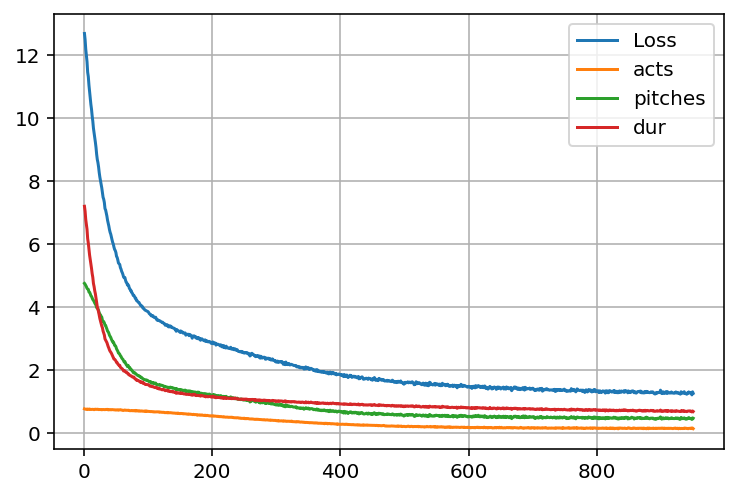

In [49]:
losses = checkpoint['losses']
plt.plot(range(1, len(losses['tot'])+1), losses['tot'], label='Loss')
plt.plot(range(1, len(losses['acts'])+1), losses['acts'], label='acts')
plt.plot(range(1, len(losses['pitches'])+1), losses['pitches'], label='pitches')
plt.plot(range(1, len(losses['dur'])+1), losses['dur'], label='dur')
#plt.plot(range(1, len(losses['kld'])+1), losses['kld'], label='kld')
plt.grid()
plt.legend()

Accuracy plot

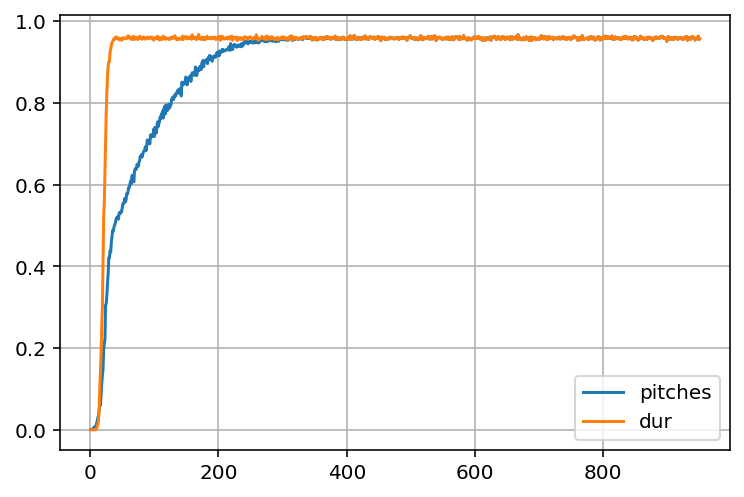

In [51]:
accs = checkpoint['accuracies']
#plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
#plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.grid()
plt.legend()

Learning rate plot

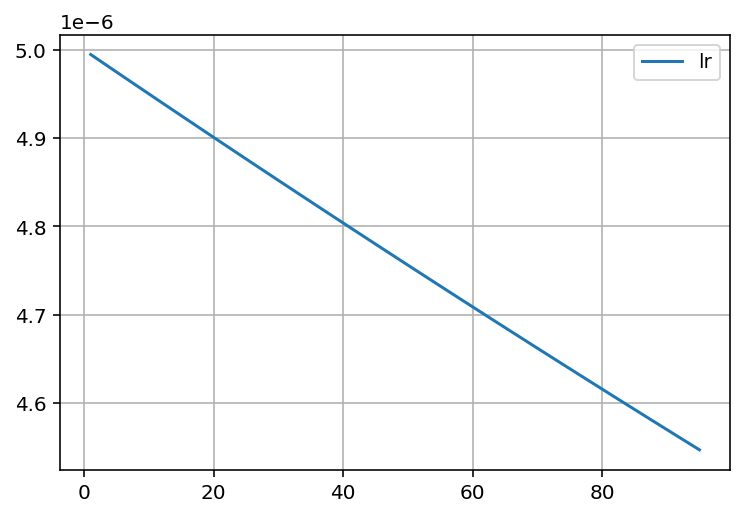

In [45]:
plt.plot(range(1, len(checkpoint['lrs'])+1), checkpoint['lrs'], label='lr')
plt.grid()
plt.legend()

# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape